In [1]:
from xgboost import XGBRegressor
from data import *
from model import *

taxi_type = YELLOW
train_sql = getSqlForModeling(taxi_type, isTrain=True)
test_sql = getSqlForModeling(taxi_type, isTrain=False)

model = XGBRegressor(n_estimators=1000, 
                     learning_rate=0.1, 
                     max_depth=9, 
                     n_iter_no_change=10)

# Training
with DR.engn.connect() as conn:
    processed = 0
    for df in pd.read_sql(train_sql, conn, chunksize=CHUNK_SIZE):
        processed += len(df)
        X = df[FEATURES]
        y = df[VARIABLE]

        model.fit(X, y)
        O.out(f'Trained {processed} rows')

storeModel(model, f'{taxi_type}_{VARIABLE}_{XGB_REGRESSOR}')

# Predictions
with DR.engn.connect() as conn:
    processed = 0
    y_test = []
    y_pred = []
    for df in pd.read_sql(test_sql, conn, chunksize=CHUNK_SIZE):
        processed += len(df)
        X = df[FEATURES]
        y_test.append(df[VARIABLE])

        y_pred.append(model.predict(X))
        O.out(f'Predicted {processed} rows')

# Performance
merged_y_test = pd.concat(y_test, ignore_index=True)
merged_y_pred = np.concatenate(y_pred)

showPerformance(merged_y_test, merged_y_pred)

sql engine ready
Model Accuracy Metrics:
Mean Absolute Error (MAE): 0.61
Root Mean Squared Error (RMSE): 2.24
R-squared (Accuracy): 0.98


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math
from model import *
from data import *

def getSqlForModeling(taxi_type, isTrain):
    trip_count = {
        "green": 3071981,
        "yellow": 120393705
    }
    train_size = {
        "green": math.floor(0.8 * trip_count[GREEN]),
        "yellow": math.floor(0.8 * trip_count[YELLOW])
    }
    test_size = {
        "green": trip_count[GREEN] - train_size[GREEN],
        "yellow": trip_count[YELLOW] - train_size[YELLOW],
    }

    columns = COMMON_FETCH_COLUMNS 
    
    # init with limit clause for test
    limit_clause = f'LIMIT {test_size[taxi_type]} OFFSET {train_size[taxi_type]}'
    
    if isTrain:
        limit_clause = f'LIMIT {train_size[taxi_type]}'
    
    sql = f'''
        {selFrom(columns, 2020, taxi_type)}
        WHERE {' AND '.join(commonConditions(2020))}
        UNION ALL
        {selFrom(columns, 2021, taxi_type)}
        WHERE {' AND '.join(commonConditions(2021))}
        UNION ALL
        {selFrom(columns, 2022, taxi_type)}
        WHERE {' AND '.join(commonConditions(2022))}
        UNION ALL
        {selFrom(columns, 2023, taxi_type)}
        WHERE {' AND '.join(commonConditions(2023))}
        {limit_clause}
    '''

    return text(sql)

# getSqlForModeling(GREEN, isTrain=False)

In [21]:
taxi_type = YELLOW
train_sql = getSqlForModeling(taxi_type, isTrain=True)
test_sql = getSqlForModeling(taxi_type, isTrain=False)

In [22]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=1000, 
                     learning_rate=0.1, 
                     max_depth=9,
                     n_iter_no_change=10)

with DR.engn.connect() as conn:
    processed = 0
    for df in pd.read_sql(train_sql, conn, chunksize=CHUNK_SIZE):
        processed += len(df)
        X = df[FEATURES]
        y = df[VARIABLE]

        model.fit(X, y)
        O.out(f'Trained {processed} rows')


In [24]:
# 5. Predictions
# y_pred = model.predict(X_test)
with DR.engn.connect() as conn:
    processed = 0
    y_test = []
    y_pred = []
    for df in pd.read_sql(test_sql, conn, chunksize=CHUNK_SIZE):
        processed += len(df)
        X = df[FEATURES]
        y_test.append(df[VARIABLE])

        y_pred.append(model.predict(X))
        O.out(f'Predicted {processed} rows')

In [ ]:
# merge y_test
merged_y_test = pd.concat(y_test, ignore_index=True)
# merge y_pred
merged_y_pred = np.concatenate(y_pred)

In [33]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import plotly.graph_objects as go

def showPerformance(y_test, y_pred):
    # Calculate Model Accuracy Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"Model Accuracy Metrics:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (Accuracy): {r2:.2f}")

    # Limit data to 150 samples for visualization
    samples_to_plot = 150
    y_test_limited = y_test[:samples_to_plot].reset_index(drop=True)
    y_pred_limited = y_pred[:samples_to_plot]

    # Create Line Chart with Plotly
    fig = go.Figure()

    # Actual Values
    fig.add_trace(go.Scatter(
        x=y_test_limited.index, 
        y=y_test_limited, 
        mode="lines+markers", 
        name="Actual",
        line=dict(color="blue")
    ))

    # Predicted Values
    fig.add_trace(go.Scatter(
        x=y_test_limited.index, 
        y=y_pred_limited, 
        mode="lines+markers", 
        name="Predicted",
        line=dict(color="orange")
    ))

    # Customize Layout
    fig.update_layout(
        title="Actual vs Predicted Fare Amount (Limited to 150 Samples)",
        xaxis_title="Sample Index",
        yaxis_title="Fare Amount ($)",
        legend=dict(x=0.5, y=1.15, xanchor="center", yanchor="top"),
        template="plotly_white"
    )

    # Show the plot
    fig.show()

showPerformance(merged_y_test, merged_y_pred)

Model Accuracy Metrics:
Mean Absolute Error (MAE): 0.61
Root Mean Squared Error (RMSE): 2.24
R-squared (Accuracy): 0.98


sql engine ready
Mean Squared Error: 5.016349040137176


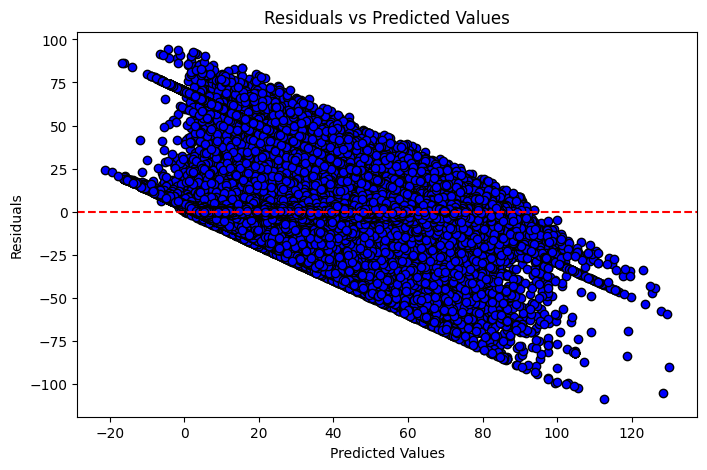

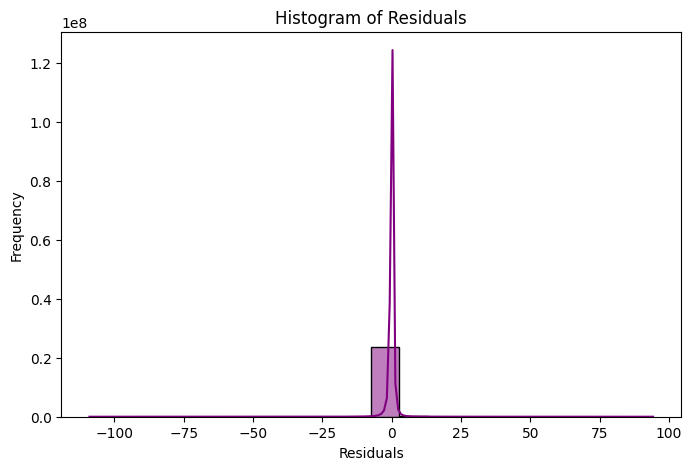

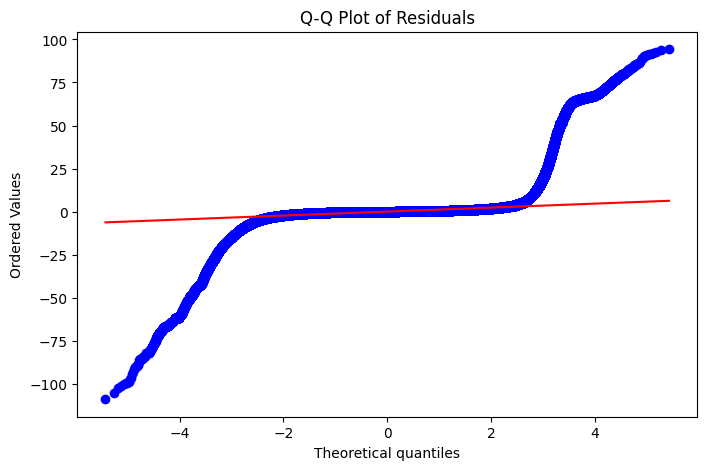

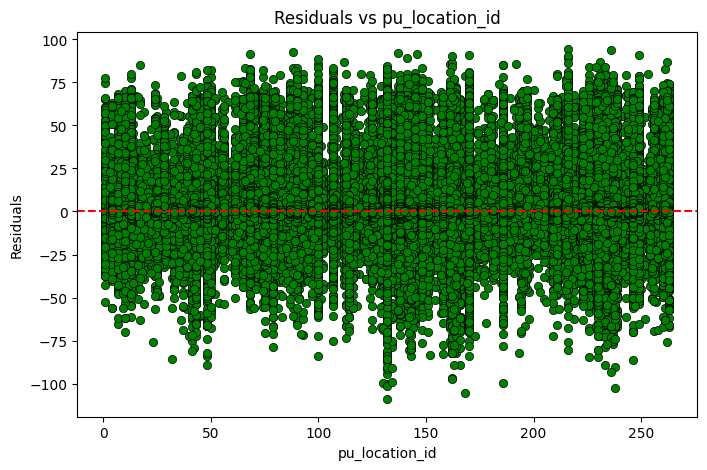

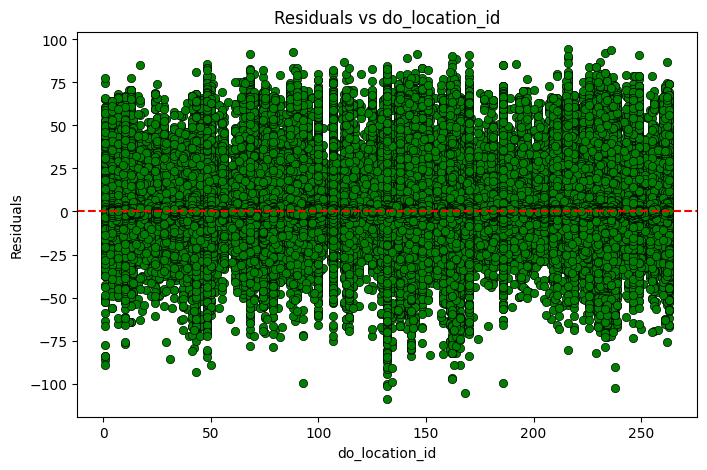

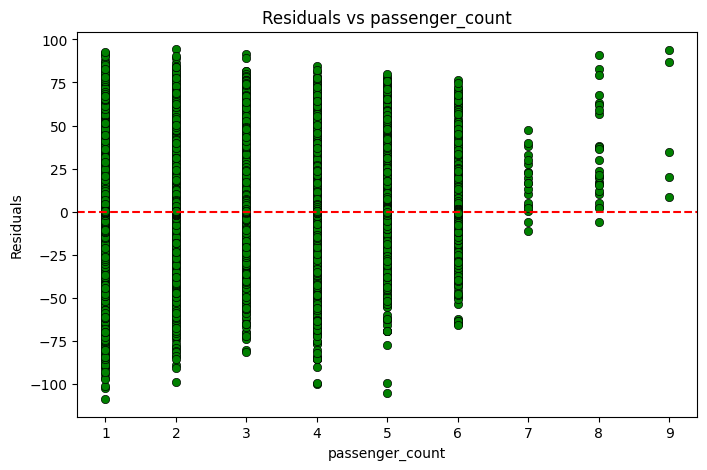

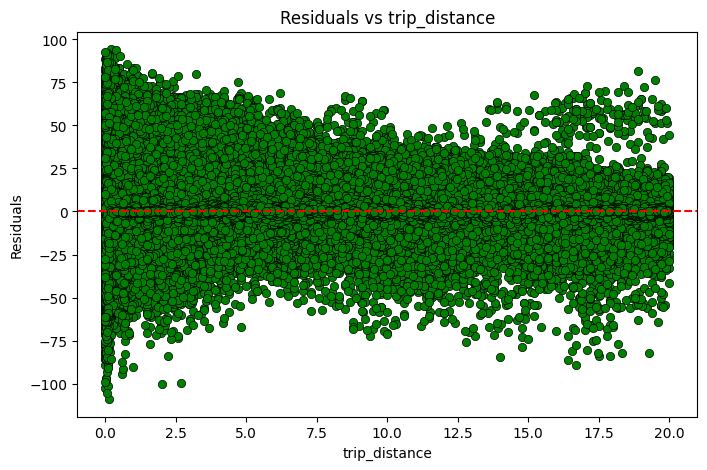

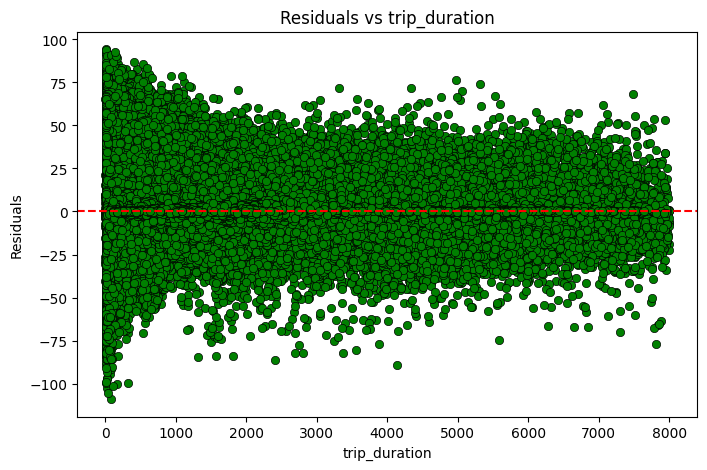

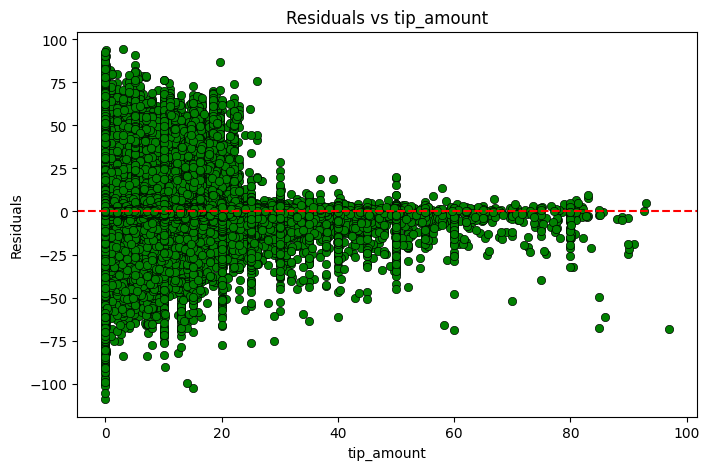

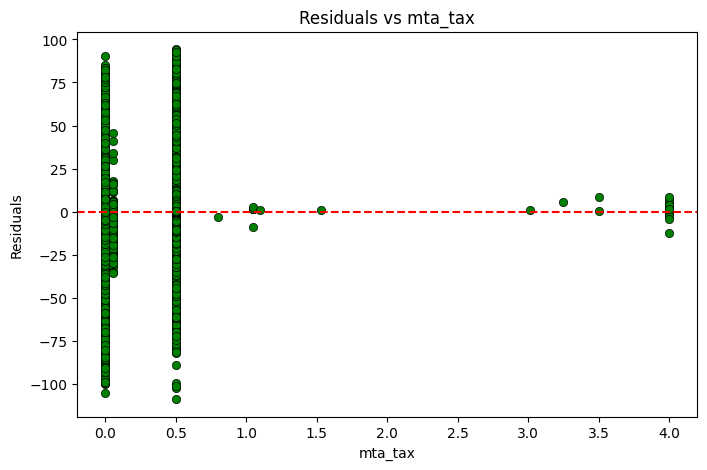

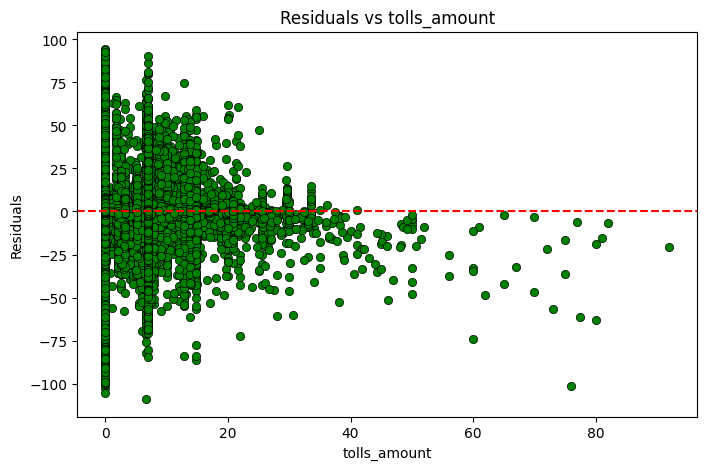

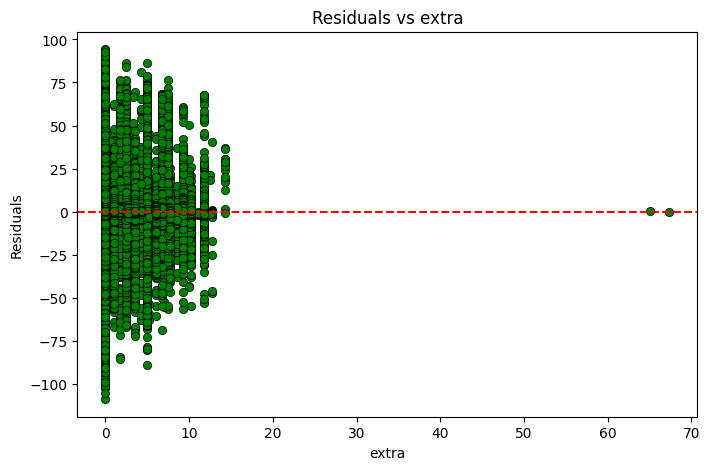

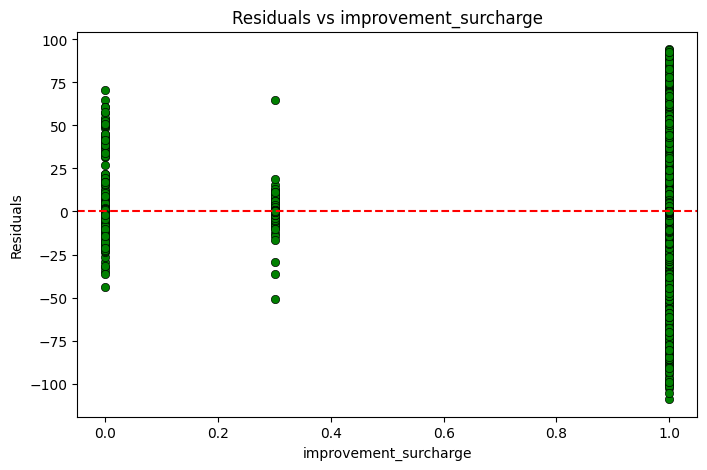

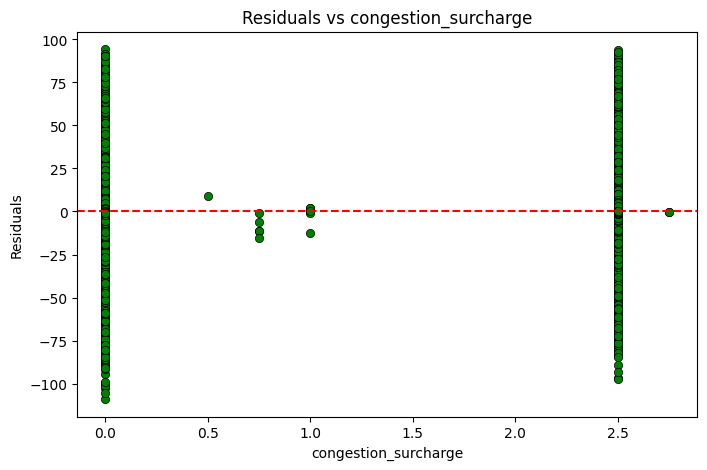

In [1]:
# Residual Analysis
from data import *
from model import *

taxi_type = YELLOW
# train_sql = getSqlForModeling(taxi_type, isTrain=True)
test_sql = getSqlForModeling(taxi_type, isTrain=False)

model = loadModel(f'{taxi_type}_{VARIABLE}_{XGB_REGRESSOR}')

# Predictions
with DR.engn.connect() as conn:
    processed = 0
    y_t_chunk = []
    y_p_chunk = []
    X_t_chunk = []
    for df in pd.read_sql(test_sql, conn, chunksize=CHUNK_SIZE):
        processed += len(df)
        X = df[FEATURES]
        X_t_chunk.append(X)
        y_t_chunk.append(df[VARIABLE])

        y_p_chunk.append(model.predict(X))
        O.out(f'Predicted {processed} rows')

# Performance
X_test = pd.concat(X_t_chunk, ignore_index=True)
y_test = pd.concat(y_t_chunk, ignore_index=True)
y_pred = np.concatenate(y_p_chunk)


residualAnalysis(X_test, y_test, y_pred)